

<h1 style='background-color:Violet; font-family:newtimeroman; font-size:180%; text-align:center; border-radius: 15px 50px;' > Chest Cancer Classification - VVG16 </h1>


<h1 style='background-color:Violet; font-family:newtimeroman; font-size:180%; text-align:center; border-radius: 15px 50px;' >  VGG16 Architecture </h1>









In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import skimage.io
import os 
import tqdm
import glob
import tensorflow 

from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.color import grey2rgb

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.utils import to_categorical
from keras import optimizers
from tensorflow.keras.optimizers import Adam

from keras.callbacks import Callback,ModelCheckpoint,ReduceLROnPlateau
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
import keras.backend as K

#import tensorflow_addons as tfa
#from tensorflow.keras.metrics import Metric
#from tensorflow_addons.utils.types import AcceptableDTypes, FloatTensorLike
from typeguard import typechecked
from typing import Optional

In [2]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [3]:
# generating train/test/valid
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2,
                                  
        rotation_range=5,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        #zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255
                                  )

In [4]:
# filepath is CTscns1 for initial model building/testing
# with vgg16 models the target size is always 224x224
train_dataset  = train_datagen.flow_from_directory(directory = '/Users/elliotttrott/Desktop/CTscns1C/train',
                                                   target_size = (224,224),
                                                   class_mode = 'categorical',
                                                   batch_size = 64)

# validation data
valid_dataset = valid_datagen.flow_from_directory(directory = '/Users/elliotttrott/Desktop/CTscns1C/val',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  batch_size = 64)

# test data
test_dataset = test_datagen.flow_from_directory(directory = '/Users/elliotttrott/Desktop/CTscns1C/test',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  batch_size = 64)

Found 618 images belonging to 4 classes.
Found 39 images belonging to 4 classes.
Found 124 images belonging to 4 classes.


In [5]:
# loading in the base model VGG16
base_model_2 = tf.keras.applications.VGG16(input_shape=(224,224,3),include_top=False,weights="imagenet")
# using the weights used in the imagenet competition

2022-08-02 09:09:37.261881: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
# Freezing layers

for layer in base_model_2.layers[:-8]:
    layer.trainable=False

In [7]:
# Adding sequential layers/ building model - some dropout for overfitting

model=Sequential()
model.add(base_model_2)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(4,activation='softmax')) # must use softmax at last layer

In [8]:
# Model Summary

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 dropout (Dropout)           (None, 7, 7, 512)         0         
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 batch_normalization (BatchN  (None, 25088)            100352    
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 32)                802848    
                                                                 
 batch_normalization_1 (Batc  (None, 32)               128       
 hNormalization)                                        

This is showing us the total parameters and other information on our newly built model

In [ ]:
# freeze for now
#from tensorflow.keras.utils import plot_model
#from IPython.display import Image
#plot_model(model, to_file='convnet.png', show_shapes=True,show_layer_names=True)
#Image(filename='convnet.png')

In [15]:
# defing f1 score using predictions

def f1_score(y_true, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [16]:
# use accuracy as unifying metric, for now just experiment
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),f1_score
]

In [17]:
# adding early stopping and other call backs to avoid massive training times
reduce = ReduceLROnPlateau(monitor = 'val_loss',patience = 3,verbose = 1,factor = 0.50, min_lr = 1e-7)# reducing learning rate, stopping overfitting

early_stopping = EarlyStopping(verbose=1, patience=3)

checkpoint = ModelCheckpoint('model_2_2.h5')

In [18]:
# compiling the model using adam as opt. and using x entropy for loss
model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = METRICS)

In [19]:
# training the model over the training data, using validation data also
%time
history=model.fit(train_dataset,validation_data=valid_dataset,epochs = 40,verbose = 1,callbacks=[reduce,early_stopping,checkpoint])

CPU times: user 4 µs, sys: 7 µs, total: 11 µs
Wall time: 40.1 µs
Epoch 1/40
10/10 [==============================] - 94s 10s/step - loss: 1.3344 - accuracy: 0.7395 - f1_score: 0.1338 - val_loss: 84.0018 - val_accuracy: 0.6923 - val_f1_score: 0.3846 - lr: 0.0010
Epoch 2/40
10/10 [==============================] - 92s 9s/step - loss: 1.3059 - accuracy: 0.7488 - f1_score: 0.1674 - val_loss: 2.7799 - val_accuracy: 0.6538 - val_f1_score: 0.2703 - lr: 0.0010
Epoch 3/40
10/10 [==============================] - 93s 9s/step - loss: 1.2965 - accuracy: 0.7415 - f1_score: 0.1336 - val_loss: 3.7809 - val_accuracy: 0.6987 - val_f1_score: 0.0408 - lr: 0.0010
Epoch 4/40
10/10 [==============================] - 94s 9s/step - loss: 1.2838 - accuracy: 0.7431 - f1_score: 0.1136 - val_loss: 3.8270 - val_accuracy: 0.6923 - val_f1_score: 0.3514 - lr: 0.0010
Epoch 5/40
10/10 [==============================] - ETA: 0s - loss: 1.2236 - accuracy: 0.7500 - f1_score: 0.1237
Epoch 00005: ReduceLROnPlateau reducing 

In [20]:
# evaluating model over the test data
model.evaluate(test_dataset)

2/2 [==============================] - 8s 4s/step - loss: 3.7696 - accuracy: 0.7056 - f1_score: 0.2687


[3.769587516784668, 0.7056451439857483, 0.2687418460845947]

In [ ]:
# accuracy is 69.5% 

In [21]:
model.save("/Users/elliotttrott/Desktop/Diss_saved_models/VGGmod2")

INFO:tensorflow:Assets written to: /Users/elliotttrott/Desktop/Diss_saved_models/VGGmod2/assets


In [ ]:
# accuracy too low, need to try something else.

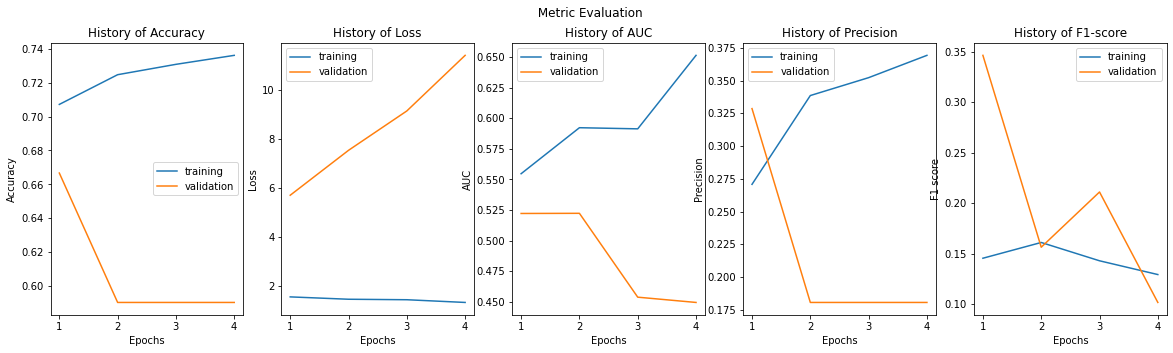

In [24]:
# PLOTTING RESULTS 

def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision,f1,val_f1):
    
    fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize= (20,5))
    fig.suptitle(" Metric Evaluation ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])
    
    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])
    
    ax5.plot(range(1, len(f1) + 1), f1)
    ax5.plot(range(1, len(val_f1) + 1), val_f1)
    ax5.set_title('History of F1-score')
    ax5.set_xlabel('Epochs')
    ax5.set_ylabel('F1 score')
    ax5.legend(['training', 'validation'])


    plt.show()
    

Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'],
               history.history['auc'],history.history['val_auc'],
               history.history['precision'],history.history['val_precision'],
               history.history['f1_score'],history.history['val_f1_score']
              )

In [ ]:
# other accuracies
# ,
#      tf.keras.metrics.Recall(name='recall'),
 #     tf.keras.metrics.AUC(name='auc'),
  #    tf.keras.metrics.Precision(name='precision'),
   #   f1_score,